# Kaggle Taxi Cab Analysis

## Loading Libraries and Datasets

Importing pandas, pytorch and numpy

In [1]:
import pandas as pd
import torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import math
import os 
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.9.0+cu111


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Read in the train.csv file into a pandas dataframe.

In [3]:
df_tr = pd.read_csv("train.csv")

In [4]:
print(df_tr.shape)
df_tr.head()

(1710670, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


Removing the 10 trips with MISSING_DATA true meaning they have no POLYLINE and thus no travel time.

In [5]:
missingIndex = df_tr[df_tr["MISSING_DATA"]].index
df_tr.drop(missingIndex , inplace=True)

In [6]:
print(df_tr.shape)
df_tr.head()

(1710660, 9)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


# Get Computed Travel Time

Add a "LEN" column to the dataframe with a trip's travel time calculated by getting the number of elements in the POLYLINE and multiplying by 15 seconds. A single element in the POLYLINE represents a start longtitude/latitude and an end longtitude/latitude and represents 15 seconds of travel.

In [7]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

Translates the TIMESTAMP which is in epoch time into YR, MON, DAY, HR, WK columns.

In [8]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.minute

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK", "MIN"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")


In [9]:
idMap = {}
for (i, id) in enumerate(np.unique(df_tr['TAXI_ID'])):
    idMap[id] = i

In [10]:
def applyMap(id):
    return idMap[id]
df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(applyMap)

In [11]:
df_trimmed = df_tr.copy()

In [12]:
df_trimmed = df_trimmed.reset_index()

In [13]:
for colum in df_trimmed:
    unique_values = np.unique(df_trimmed[colum])
    nr_values = len(unique_values)
    if nr_values < 10:
        print("The number of unique values for features {} : {} --- {}".format(colum, nr_values,unique_values))
    else:
         print("The number of unique values for features {} : {}".format(colum, nr_values))

The number of unique values for features index : 1710660
The number of unique values for features TRIP_ID : 1710579
The number of unique values for features CALL_TYPE : 3 --- ['A' 'B' 'C']
The number of unique values for features ORIGIN_CALL : 57106
The number of unique values for features ORIGIN_STAND : 64
The number of unique values for features TAXI_ID : 448
The number of unique values for features TIMESTAMP : 1655357
The number of unique values for features DAY_TYPE : 1 --- ['A']
The number of unique values for features MISSING_DATA : 1 --- [False]
The number of unique values for features POLYLINE : 1703640
The number of unique values for features LEN : 1254
The number of unique values for features YR : 2 --- [2013 2014]
The number of unique values for features MON : 12
The number of unique values for features DAY : 31
The number of unique values for features HR : 24
The number of unique values for features WK : 7 --- [0 1 2 3 4 5 6]
The number of unique values for features MIN : 6

# Feature Engineering

For this, the chosen features are the hours, month and day that the trip occured on and the call_type. Instead of the categorical representation, their one hot representations will be used. These will be combined into a tensor with the shape [1710660, 72] or in otherwords we have 1710660 feature vectors each of length 72. The length of the trips will be turned into a tensor as well and we want its shape to be [1710660, 1] so we might need to reshape it.

In [14]:
def transform(data, num_category):
    one_hot = np.zeros(num_category, dtype=np.float16)
    one_hot[data] = 1
    return one_hot

def transform60(data):
    return transform(data, 60)

def transform24(data):
    return transform(data, 24)

def transform12(data):
    return transform(data, 13)[1:13]

def transfrom7(data):
    return transform(data, 7)

def transform31(data):
    return transform(data, 32)[1:32]

def transform448(data):
    return transform(data, 448)

def transformCallType(data):
    if data == 'A':
        return (1,0,0)
    elif data == 'B':
        return (0,1,0)
    else :
        return (0,0,1)

def parseOriginCall(data):
    if data != data:
        res = 0
    else:
        res = 1
    return res

def parseOriginStand(data):
    if data != data:
        res = 0
    else:
        res = 1
    return res

In [15]:
def getFeatureVectors(dataframe):
    one_hot_hours = dataframe["HR"].apply(transform24)
    one_hot_month = dataframe["MON"].apply(transform12)
    call_type = dataframe["CALL_TYPE"].apply(transformCallType)
#     one_hot_min = dataframe["MIN"].apply(transform60)
    taxi_id = dataframe["TAXI_ID"].apply(transform448)
    one_hot_dow = dataframe["WK"].apply(transform12)
    one_hot_day = dataframe["DAY"].apply(transform31)
    o_call = dataframe["ORIGIN_CALL"].apply(parseOriginStand)
    o_stand = dataframe["ORIGIN_STAND"].apply(parseOriginStand)
    
    hours = torch.tensor(one_hot_hours, dtype=torch.float32)
    month = torch.tensor(one_hot_month, dtype=torch.float32)
    calls = torch.tensor(call_type, dtype=torch.float32)
#     minutes = torch.tensor(one_hot_min, dtype=torch.float32)
    dayofweek = torch.tensor(one_hot_dow, dtype = torch.float32)
    day = torch.tensor(one_hot_day, dtype = torch.float32)
    o_call = torch.tensor(o_call, dtype = torch.float32).reshape(-1,1)
    o_stand = torch.tensor(o_stand, dtype = torch.float32).reshape(-1,1)
    taxi_id = torch.tensor(taxi_id, dtype = torch.float32)
    
    fv = torch.cat((hours, month), dim=1)
    fv = torch.cat((fv, dayofweek), dim=1)
    fv = torch.cat((fv, day), dim=1)
    fv = torch.cat((fv, calls), dim=1)
    fv = torch.cat((fv, o_call), dim=1)
    fv = torch.cat((fv, o_stand), dim=1)
    fv = torch.cat((fv, taxi_id), dim = 1)
    return fv

In [16]:
raw_X = getFeatureVectors(df_trimmed)

In [17]:
#the y values will be the actual trip times
raw_y = torch.tensor(df_trimmed["LEN"].values, dtype=torch.float32)

In [18]:
print(f"{raw_X.shape=} {raw_X.size()=}") 
print(f"{raw_y.shape=} {raw_y.size()=}") 

raw_X.shape=torch.Size([1710660, 532]) raw_X.size()=torch.Size([1710660, 532])
raw_y.shape=torch.Size([1710660]) raw_y.size()=torch.Size([1710660])


In [19]:
#randomly populate the training and testing set with 1.5 million in the training and the rest in the testing
def sampleData(raw_X, raw_Y, length, numSample):
    perm = torch.randperm(length)
    train_idx, test_idx = perm[:int(numSample * 0.8)], perm[int(numSample * 0.8):numSample]
    X_tr, Y_tr = raw_X[train_idx], raw_Y[train_idx]
    X_te, Y_te = raw_X[test_idx], raw_Y[test_idx]
    return X_tr, Y_tr, X_te, Y_te

In [20]:
X_tr, Y_tr, X_te, Y_te = sampleData(raw_X, raw_y, len(df_trimmed), len(df_trimmed))

In [21]:
print(f"{X_tr.shape=} {X_te.shape=}") 
print(f"{Y_tr.shape=} {Y_te.size()=}") 

X_tr.shape=torch.Size([1368528, 532]) X_te.shape=torch.Size([342132, 532])
Y_tr.shape=torch.Size([1368528]) Y_te.size()=torch.Size([342132])


In [22]:
#do any reshapings that has to be done
X_train, X_test = X_tr.reshape((-1, 532)), X_te.reshape((-1, 532))
y_train, y_test = Y_tr.reshape((-1, 1)), Y_te.reshape((-1, 1))

In [23]:
print(f"{X_train.shape=} {X_test.shape=}") 
print(f"{y_train.shape=} {y_test.size()=}") 

X_train.shape=torch.Size([1368528, 532]) X_test.shape=torch.Size([342132, 532])
y_train.shape=torch.Size([1368528, 1]) y_test.size()=torch.Size([342132, 1])


# Creating Model

Define a Model that will be used

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(532, 1)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(100, 1)
#         self.fc3 = nn.Linear(20, 1)
#         self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
#         x = self.fc1(x).reshape(1,43)
# #         x = F.normalize(x).reshape(-1)
#         print(x)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x


model = Net().to(device)

loss_fn = nn.MSELoss()

lr = 0.001
opt = optim.SGD(model.parameters(), lr=lr)

In [26]:
train_err = []
test_err = []
parameters = []
epoch = 100
batch_size = 512
for i_epoch in range(epoch):
    permutation = torch.randperm(X_train.size()[0])
    running_loss = 0
    n = 0
    for i in range(0,X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
        outputs = model(batch_x)
        loss = loss_fn(outputs,batch_y)
        running_loss += loss.item()
        n+=1
        opt.zero_grad() 
        loss.backward()
        opt.step()
    
    loss_rate = math.sqrt(running_loss / n)
    train_err.append(loss_rate)
    model.eval()
    with torch.no_grad():
        test_loss = math.sqrt(loss_fn(model(X_test.to(device)), y_test.to(device)).item())
        test_err.append(test_loss)
    if (i_epoch % 10 == 0):
        print("Epoch: {0} \t Training Loss: {1:.8f} \t Training Loss: {2:.8f}".format(i_epoch+1, loss_rate, test_loss))

Epoch: 1 	 Training Loss: 706.82603364 	 Training Loss: 662.74820822
Epoch: 11 	 Training Loss: 677.88894461 	 Training Loss: 655.75612368
Epoch: 21 	 Training Loss: 675.62720561 	 Training Loss: 653.56964529
Epoch: 31 	 Training Loss: 674.08872147 	 Training Loss: 652.08550053
Epoch: 41 	 Training Loss: 672.94110236 	 Training Loss: 650.97743817
Epoch: 51 	 Training Loss: 672.04425577 	 Training Loss: 650.12635791
Epoch: 61 	 Training Loss: 671.32010407 	 Training Loss: 649.44988740
Epoch: 71 	 Training Loss: 670.72852643 	 Training Loss: 648.90282400
Epoch: 81 	 Training Loss: 670.22831452 	 Training Loss: 648.44899086
Epoch: 91 	 Training Loss: 669.83323771 	 Training Loss: 648.06700560


In [27]:
os.makedirs('./saved_models/', exist_ok=True)
torch.save(model.state_dict(), './saved_models/timestampid-1.pth')

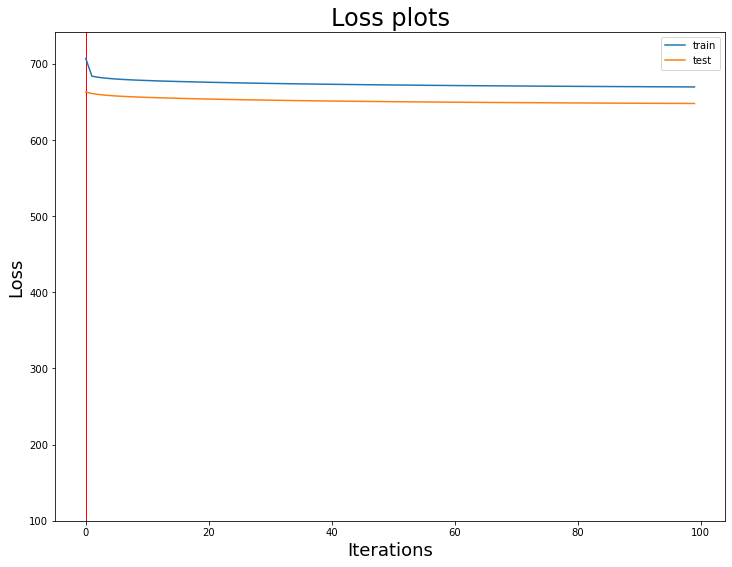

In [28]:
# print(train_err[epoch - 1 ])
# print(test_err[epoch - 1])

def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(100)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")

# Create Prediction File

After the model has been trained, we can then run it on the public test cases. The public test cases are given in the test_public.csv file. The same transformation we applied to the training dataset has to be done to the test_public.csv file in order to run the model on it.

In [29]:
predict = pd.read_csv("test_public.csv")

In [30]:
predict[["YR", "MON", "DAY", "HR", "WK", "MIN"]] = predict[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
predict.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,MIN
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,17,3,57
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,17,3,50
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,17,3,49
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,17,3,58
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,17,3,59


In [31]:
predict["TAXI_ID"] = predict["TAXI_ID"].apply(applyMap)

In [32]:
predict_x = getFeatureVectors(predict)

print(predict_x[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [33]:
model.eval()
with torch.no_grad():
    o = model(predict_x.to(device))
o = o.reshape(-1)
out = o.cpu().numpy()

In [34]:
out

array([ 783.10364,  718.5983 ,  703.18463,  692.8423 ,  693.8449 ,
       1105.098  ,  714.3889 ,  837.7157 ,  665.7354 ,  775.7811 ,
        748.8418 ,  933.28455,  845.26245,  991.302  ,  915.7383 ,
        916.2012 ,  862.04517,  969.00366,  781.0318 ,  898.95325,
        734.9043 ,  881.298  ,  793.4846 ,  808.03845,  757.5753 ,
        751.4469 ,  739.0635 ,  801.574  ,  801.66565,  786.82935,
        718.996  ,  757.51196,  893.67505,  975.59375,  998.64197,
        892.98224,  910.6399 ,  772.44446,  736.7731 ,  756.626  ,
        730.71265,  855.093  , 1013.1168 ,  709.0245 ,  726.29297,
        815.3854 ,  883.9507 ,  926.05804,  883.6682 ,  735.9662 ,
        854.7445 ,  781.1843 ,  780.03986,  769.9241 ,  781.49286,
        716.78595,  702.7634 ,  741.04596, 1099.5037 ,  829.1167 ,
        810.77246,  866.28345,  832.81274,  905.05554,  683.7569 ,
        755.4075 ,  737.33923,  749.70245,  946.80597,  688.1197 ,
        878.98975,  985.3745 ,  770.3566 ,  965.5193 ,  732.41

After getting the output from the model, there should be 320 datapoints. We can open the sampleSubmission.csv and then add a new column for the TRAVEL_TIME and put in our predicted travel time. The csv then can be saved.

In [36]:
filePath = "./submissions/timestamp_id_pred_1.csv"

df_sample = pd.read_csv("sampleSubmission.csv")

for i in range(320):
    df_sample.at[i, "TRAVEL_TIME"] = float(out[i])

os.makedirs('./submissions/', exist_ok=True)
df_sample.to_csv(filePath, index=None, mode="+x")

FileExistsError: [Errno 17] File exists: './submissions/timestamp_id_pred_1.csv'

# Saving Models

After saving a model, you can load it back again like this. 

In [ ]:
new_model = Net()

In [ ]:
# make sure the model is has the same "structure" so that the "weights" can be filled in.
new_model.load_state_dict(torch.load('./saves/timestampid-1.pth'))